<a href="https://colab.research.google.com/github/stivenbg/Basics_ML/blob/main/Hybrid_AI_bias_BC_helmoltz_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-

#j'envoie tout ceci sur mon ordi ens pour utiliser ruche
import torch
import numpy as np
import scipy.io as io
import os
import matplotlib.pyplot as plt
import time
import scipy.io as io
import sys
import matplotlib.gridspec as gridspec
import torch.nn.init as init
from torchsummary import summary


sys.path.insert(0, 'Utilities/')
import os

# from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

np.random.seed(42)
import sys
import torch.nn as nn
import torch.optim as optim


In [2]:
data = io.loadmat('/content/drive/MyDrive/Doc PHD /data_helmoltz_bias_cl/_simu_50pod_2mu_biais_cl_50_sensors_with_modes.mat')

In [3]:
u_train, v_train, coordonnees, POD  = data['ETA'].T, data['V'].T, data['coordonnees'], data['trunk']
x_train = coordonnees[:,0]
y_train = coordonnees[:,1]

In [4]:
#Data
# %% ici le train cest le test, normalement ca devrait bien fonctionner ensutie je change le test
#u_train, v_train, x_train, y_train, u_test, v_test = data2['utrain'].T, data2['vtrain'].T, data2['xtrain'], data2['ytrain'], data2['utest'].T, data2['vtest'].T
#u_train, v_train, x_train, y_train = data2['utrain'].T, data2['vtrain'].T, data2['xtrain'], data2['ytrain']
#POD = data3['trunk']
# %%

#u_train = np.reshape(u_train, (101, 40))
#u_train.shape
# %%
#v_train = v_train * 5
v_train.shape
x_train.shape
y_train.shape
x_y_train = np.hstack([x_train, y_train])
x_y_train = x_y_train
# %%
# x_y_train.shape
# u_test = datatest['utest']
# u_test = u_test.T
# u_test.shape
# #u_test = u_train
# u_test.shape

#on repartit les data entre training et testing
#for data2
# u_test = u_train[401:501, :]
# v_test = v_train[401:501, :]
# #%%
# u_train = u_train[0:400, :]
# v_train = v_train[0:400, :]


#for data3 51 simu
u_test = u_train[40:49, :]
v_test = v_train[40:49, :]
#%%
u_train = u_train[0:39, :]
v_train = v_train[0:39, :]

#for data3 101 simu
# u_test = u_train[81:101, :]
# v_test = v_train[81:101, :]
# #%%
# u_train = u_train[0:80, :]
# v_train = v_train[0:80, :]

#for data 201 simu
# u_test = u_train[161:201, :]
# v_test = v_train[161:201, :]
# #%%
# u_train = u_train[0:160, :]
# v_train = v_train[0:160, :]



# # %%       v_test = v_train

# v_test = datatest['vtest']
# v_test = v_test.T
# v_test.shape

# #%% test on non scaled data
# v2 = data2['vtest']
# v2 = v_test.T
# #v_test = v_test * 5
# v2.shape
#%%

x_test, y_test = x_train, y_train
#%%
#x_test.shape
#y_test.shape

# %%
#x_test = datatest['xtest']
#x_test.shape
#y_test = datatest['ytest']
#y_test.shape
x_y_test = np.hstack([x_test, y_test])
x_y_test.shape
#%%
x_y_test.shape

#POD = np.random.rand(50, 50)


(100,)

In [7]:
#modele
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()

    # Initialization for DNNs
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l - 1]
            out_dim = layers[l]
            std = np.sqrt(2.0 / (in_dim + out_dim))
            weight = nn.Parameter(torch.randn(in_dim, out_dim) * std)
            bias = nn.Parameter(torch.randn(1, out_dim) * std)
            W.append(weight)
            b.append(bias)
        return W, b

    def fnn_B(self, X, W, b):
        A = X
        L = len(W)
        for i in range(L - 1):
            #A = torch.tanh(torch.matmul(A, W[i]) + b[i])
            A = torch.relu(torch.matmul(A, W[i]) + b[i]) #Cest cette activation qui fonctionne

        Y = torch.matmul(A, W[-1]) + b[-1]
        return Y


    # def fnn_T(self, X, W, b):
    #     A = X
    #     L = len(W)
    #     for i in range(L - 1):
    #         A = torch.tanh(torch.matmul(A, W[i]) + b[i])
    #     Y = torch.matmul(A, W[-1]) + b[-1]
    #     return Y


u_dim = 50

# Output dimension for Branch and Trunk Net
G_dim = 50

# Branch Net
layers_f = [u_dim] + [50] * 10 + [G_dim] # 10 couches de 50 de base, on teste 3 couches

# Trunk dim
x_dim = 2


# Trunk Net
layers_x = [x_dim] + [40] * 4 + [G_dim]

model = DNN()

#%%
import numpy as np
import torch

#modes locaux pour les resultats avec 501 simulations
# data = [[-0.514660025066024, -0.689931105726470],[-0.901529023901887, -0.684634452110961],[-0.742426315880807, -0.609704195299367],[-0.420074938303126, -0.668559403033777],[-0.676833160269925, -0.606629825692584],[-0.310764752315228, -0.624168119886679],[-0.887410529036195, -0.647731861395974],[-0.345745546560123, -0.750956070138724],
#     [-0.572793777573255, -0.675705166554300],[-0.262378602712648, -0.878622375807100],[-0.618988164138168, -0.647851252822911],[-0.330300265853130, -0.843395019463754],[-0.795505969889962, -0.623584676861866],[-0.418065203360059, -0.751927369077986],[-0.336598103900727, -0.843896775878294],[-0.809177750115118, -0.674059568088082],
#     [-0.640939240737637, -0.708179344710231],[-0.915561490879271, -0.747735316180328],[-0.303040561138080, -0.678234397607889],[-0.284910272855368, -0.686375898447151],[-0.234569937053815, -0.812985204323050],[-0.330364131152862, -0.902254764441025],[-0.541797819011733, -0.715464567660477],[-0.874465583815514, -0.646097534119368],
#     [-0.908432210813868, -0.632065179060537],[-0.351644520001309, -0.657581171467405],[-0.655850869067775, -0.706258696757199],[-0.680170151727740, -0.682902712753792],[-0.441320414098538, -0.821339106530909],[-0.302301587987237, -0.772843834397822],[-0.645452318559416, -0.653569812601900],[-0.361187735845645, -0.720003252355624],
#     [-0.212953928281062, -0.965347748814264],[-0.335516292722800, -0.701324252440722],[-0.486178175096118, -0.701611552756540],[-0.915243619485525, -0.716940999486264],[-0.789287811937500, -0.637809250958212],[-0.518812011686229, -0.800742457142563],[-0.373730434592840, -0.934697205204801],[-0.793581171513283, -0.689349838624372]]

#%%

# modes locaux pour les resultats avec 1001 simulations
#input_data2 = [-0.3459,  -0.7421, -0.3391, -0.8532, -0.3048,-0.4194,-0.2397,-0.7632,-0.7112,-0.4430, -0.3836, -0.9075, -0.9155, -0.5346, -0.3763, -0.4993,-0.3200,-0.4221,-0.3184, -0.3640, -0.5890,-0.2932,-0.6207,-0.4214,-0.4484,-0.7744,-0.3246,-0.8052,-0.3483,-0.3869,-0.8546,-0.3238,-0.2879,-0.9148,-0.8857,-0.8965,-0.6248,-0.3008,-0.5907,-0.3535]

input_data2 = [-0.3459,-0.7421,-0.3391,-0.8532,-0.3048, -0.4194,-0.2397,-0.7632,-0.7112,-0.4430,-0.3836,-0.9075,-0.9155,-0.5346,-0.3763,-0.4993,-0.3200,-0.4221,-0.3184,-0.3640,-0.5890,-0.2932,-0.6207,-0.4214,-0.4484,-0.7744,-0.3246,-0.8052,-0.3483,-0.3869,-0.8546,-0.3238,-0.2879,-0.9148,-0.8857,-0.8965,-0.6248,-0.3008,-0.5907,-0.3535]

data = [[input_data2[i], input_data2[i+1]] for i in range(0, len(input_data2), 2)]

#nb of modes
n_mode = 50
# Convert the list of lists to a NumPy array

local = np.array(data)
local_pod = torch.from_numpy(local).float()


#%%
def dot(x, y):
    'Inner/dot product of vectors A and B.'
    z = 0
    for a, b in zip(x, y):
        z += a * b
    return z
def mag(x):
    'Magnitude of a vector.'
    z = 0
    for ele in x:
        z += ele ** 2
    return z ** (0.5)
# def unit(x):
#     'Normalizes a vector.'
#     z = []
#     for a in x:
#         z.append((1 / mag(x)) * a)
#     return z


def unit(x):
    'Normalizes a vector.'
    magnitude = mag(x)
    if magnitude != 0:
        z = [(1 / magnitude) * a for a in x]
        return z
    else:
        # Handle the case where the magnitude is zero
        return [0] * len(x)

def scam(a, b):
    'Scalar multiplication'
    z = []
    for x in b:
        z.append(a * x)
    return z
def add(a, b):
    'Vector addition'
    z = []
    for x, y in zip(a, b):
        z.append(x + y)
    return z
def sub(a, b):
    'Vector subtraction'
    z = []
    for x, y in zip(a, b):
        z.append(x - y)
    return z

' You can then normalize each vector (by dividing out by its length), ' \
'or make one vector v orthogonal to another w (by subtracting the appropriate multiple of w).' \
' If you do this in the right order, you will obtain an orthonormal basis ' \
'(which is when all the inner products v_i . v_j are 0 except for the diagonal inner products, ' \
'which are 1). '

#%%
def ortho(x, TOL=1e-8):
    'The Gram-Schmidt orthogonalization function.'
    Ans = [unit(x[0])]
    print(len(Ans))  # Add this line to check the length

    for j in range(1, len(x)):
        Int = []
        for anumber in range(0, j):
            print(anumber)  # Add this line to check the value of anumber
            w = scam(dot(Ans[anumber], x[j]), Ans[anumber])
            Int.append(w)
        while (len(Int) > 1):
            temp = add(Int[0], Int[1])
            Int.remove(Int[0])
            Int.remove(Int[0])
            Int.insert(1, temp)
        check = sub(list(x[j]), Int[0])
        for ele in range(0, len(check)):
            if check[ele] < TOL:
                check[ele] = 0
        try:
            Ans.append(unit(check))
        except ZeroDivisionError:
            z_v = []
            for x in range(len(check)):
                z_v.append(0)
            Ans.append([z_v])

    basis = np.reshape(Ans, (50,n_mode))
    #basis = torch.from_numpy(basis).float()
    return basis

# Projection sur le complément orthognal des modes
def projection(a, V):
    """ Compute the vector u as a linear combination of columns of V using coefficients in a. Parameters: a (numpy.ndarray): Vector of coefficients, V (numpy.ndarray): Matrix of vectors."""
    if len(a) != V.shape[1]: #Ensure a and V have compatible shapes
        raise ValueError("Number of coefficients in 'a' must match the number of columns in 'V'")
    # Perform the element-wise multiplication for each column
    #u = torch.sum(a * V, axis=1)
    # Perform the linear combination using Einstein summation
    u = torch.einsum('i,ij->i', a, V)
    return u

#%%
def linear_combi(a, V): #lc for a vector a
    result_matrix = torch.zeros(V.shape[0], V.shape[1])
    if len(a) != V.shape[1]: #Ensure a and V have compatible shapes
        raise ValueError("Number of coefficients in 'a' must match the number of columns in 'V'")
    else:
        for i in range(V.shape[1]):
            result_matrix[:, i] = a[i] * V[:, i]
        res = torch.sum(result_matrix, 0)
        return res
#print(res)
#%%
def batched_linear_combi(a,V): #lc for a matrix a
    V = torch.from_numpy(V).float()
    b = a.T
    matrix = torch.zeros(a.shape[1], a.shape[0])
    for i in range(b.shape[1]):
        matrix[:, i] = linear_combi(b[:, i], V)
    return matrix.T
#%%
np.random.seed(42)
trunk = np.random.rand(40, 1)
trunk_mode = torch.from_numpy(trunk).float()

def train_ortho(model, W_branch, b_branch, v, u, optimizer, data):
    train_vars = W_branch + b_branch
    optimizer.zero_grad()
    u_out_branch = model.fnn_B(v, W_branch, b_branch)
    u_pred = batched_linear_combi(u_out_branch, ortho(data, TOL=1e-8)) #projection of coefficient on the basis # refaire le même par batch size
    inputs = torch.ones(40, 1) # faire attention à cette ligne parce qu'elle definit la dimension de l'input. A chaque fois qu'on change la dimn  de l'input changer la dim ici
    #data_loss = torch.mean(torch.square(u_pred - u))
    loss = torch.mean(torch.square(u_pred - u)) #+ 0.0001*torch.abs(loss_ortho)
    loss.backward()
    optimizer.step()
    return loss.item(), u_pred.detach() #, data_loss.item()
#%%

def jeux(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, optimizer):
    train_vars = W_branch + b_branch + W_trunk + b_trunk
    optimizer.zero_grad()
    u_out_branch = model.fnn_B(v, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)
    return u_out_trunk.detach(),u_out_branch.detach()

#%%
def train_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, optimizer):
    train_vars = W_branch + b_branch + W_trunk + b_trunk
    optimizer.zero_grad()
    u_out_branch = model.fnn_B(v, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)
    # u_pred = torch.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
    u_pred = torch.einsum('ij,kj->ik', u_out_branch, u_out_trunk)
    #u_pred = torch.einsum('ij,kj->ik', u_out_branch, trunk_mode)


    mu = 2
    epsilon = 0.01
    inputs = torch.ones(50, 1) # faire attention à cette ligne parce qu'elle definit la dimension de l'input. A chaque fois qu'on change la dimn  de l'input changer la dim ici
    data_loss = torch.mean(torch.square(u_pred - u))
    #ortho = np.dot(u_pred[-1,:], B)
    loss_ortho = torch.mean(torch.matmul(u_pred[-1,:], B))
    #loss = data_loss + 0.00005*loss_pde
    #loss = loss_pde
    #loss = data_loss + ortho
    loss = torch.mean(torch.square(u_pred - u)) + 0.0001*torch.abs(loss_ortho)
    loss.backward()
    optimizer.step()
    return loss.item(), u_pred.detach(), loss_ortho.item(), data_loss.item()
    #return loss.item(), u_pred.detach(), data_loss.item()



def test_step(model, W_branch, b_branch, v, u, optimizer,data):     #test_step(model, W_branch, b_branch, v_test, x_y_test, u_test, optimizer, POD)
    #x_test_tensor = torch.from_numpy(x).float()
    v_test_tensor = torch.from_numpy(v).float()
    u_test_tensor = torch.from_numpy(u).float()
    #trunk = np.random.rand(40, 1)
    #trunk_mode = torch.from_numpy(trunk).float()


    with torch.no_grad():
        u_out_branch = model.fnn_B(v_test_tensor, W_branch, b_branch)
        #u_out_trunk = model.fnn_T(x_test_tensor, W_trunk, b_trunk)
        # u_pred = torch.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
        #u_pred = torch.einsum('ij,kj->ik', u_out_branch,  local_pod)   #ancien ok
        #u_pred = torch.einsum('ij,kj->ik', u_out_branch, trunk_mode)
        #u_pred = torch.einsum('ij,kj->ik', u_out_branch, u_out_trunk)
        u_pred = batched_linear_combi(u_out_branch, ortho(data,TOL=1e-8))  # projection of coefficient on the basis # refaire le même par batch size
        loss = torch.mean(torch.square(u_pred - u_test_tensor))

    return loss.item(), u_pred.detach().numpy()
#%%


<ipython-input-8-46b6341c340e>:40: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:301.)
  u_train_tensor = torch.from_numpy(u_train).float()


1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7

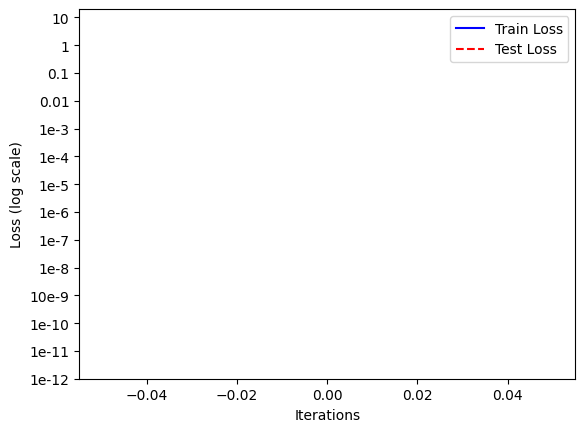

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

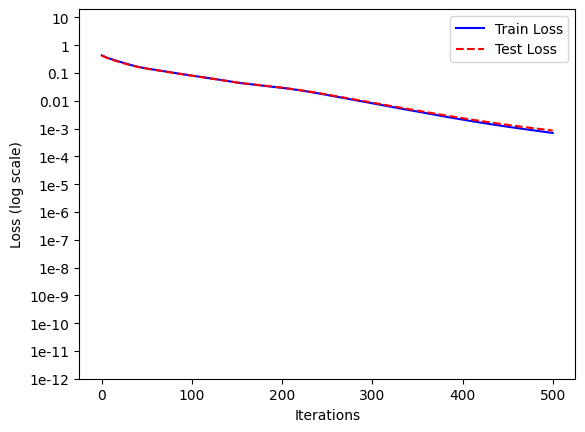

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

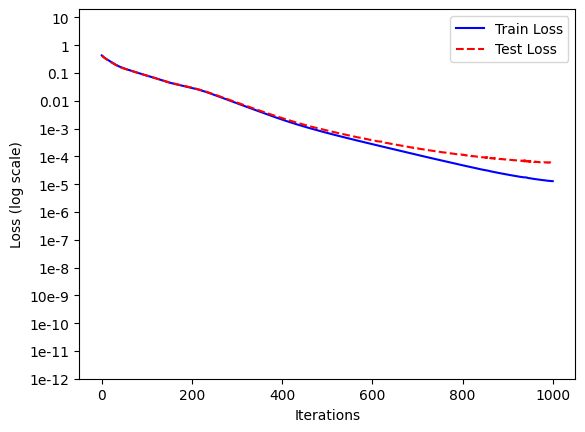

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

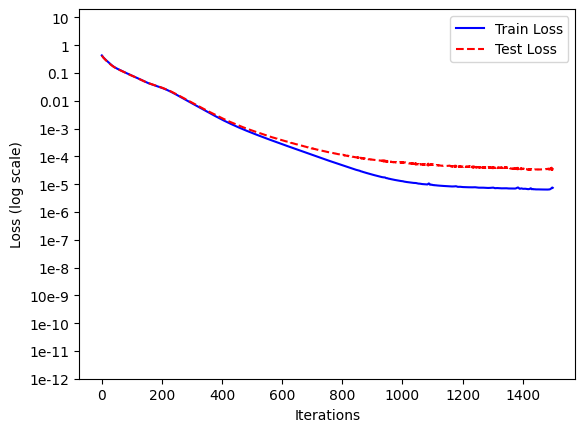

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

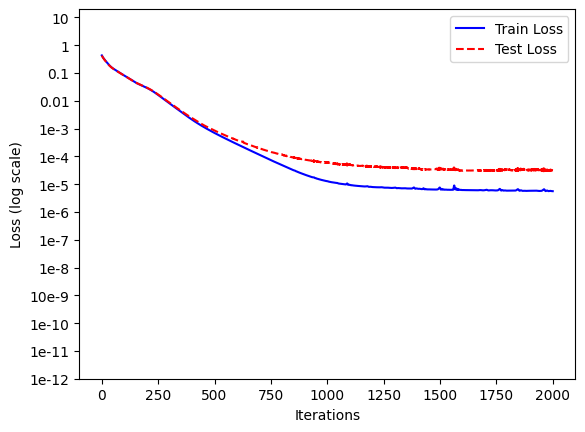

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

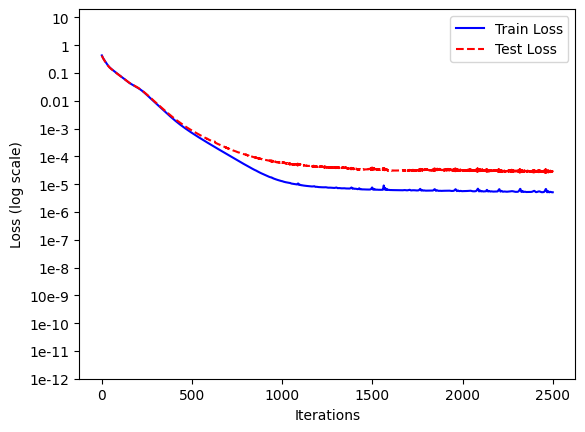

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

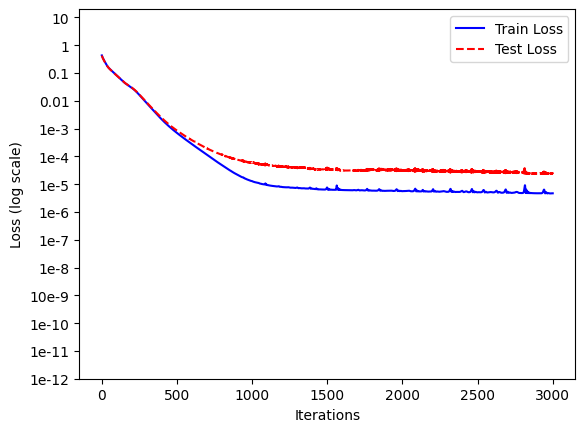

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

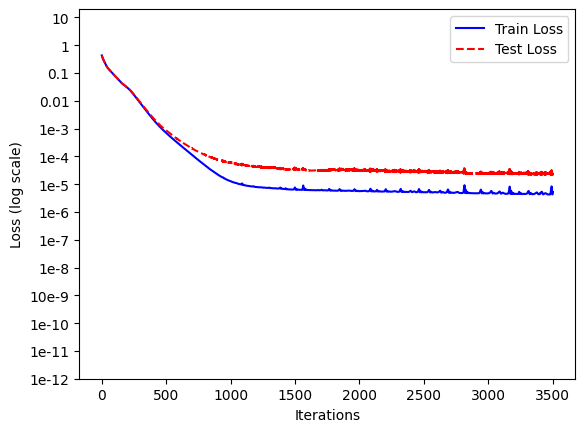

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

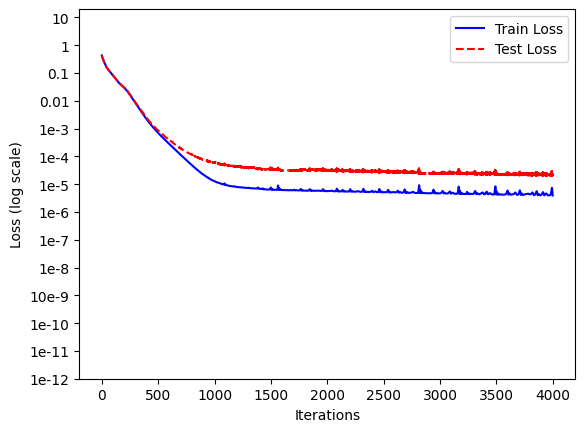

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

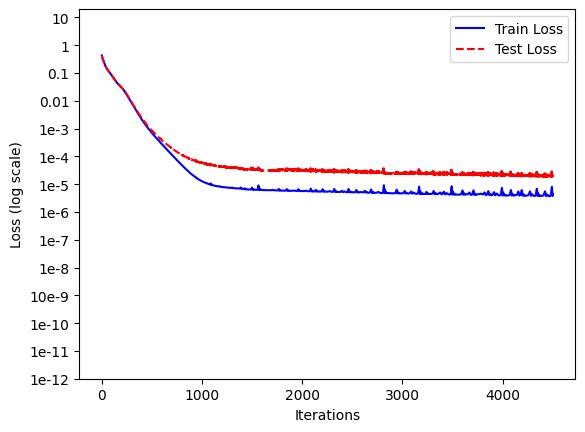

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

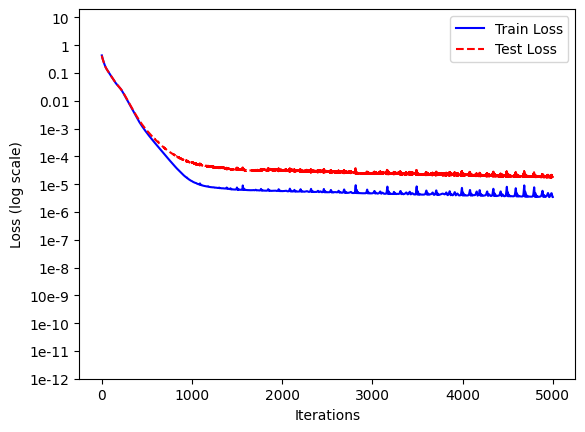

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

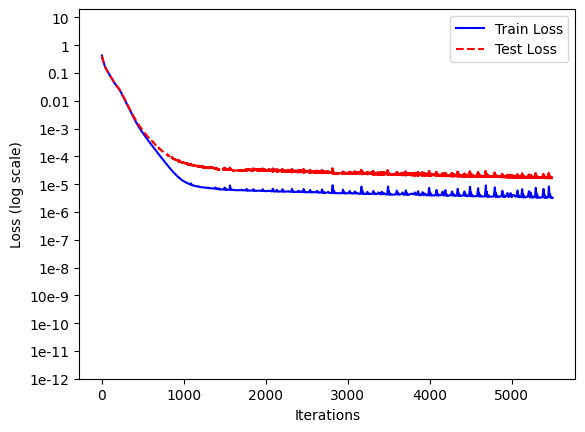

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

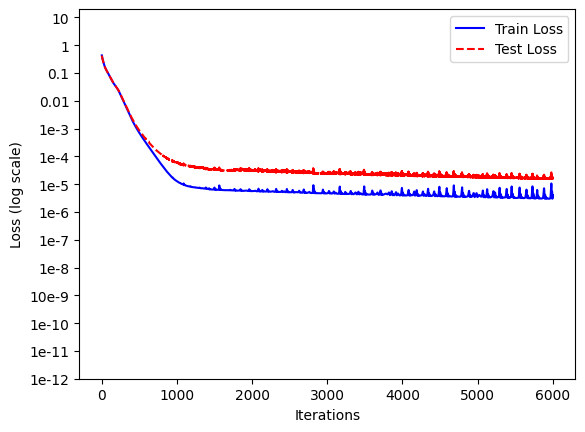

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

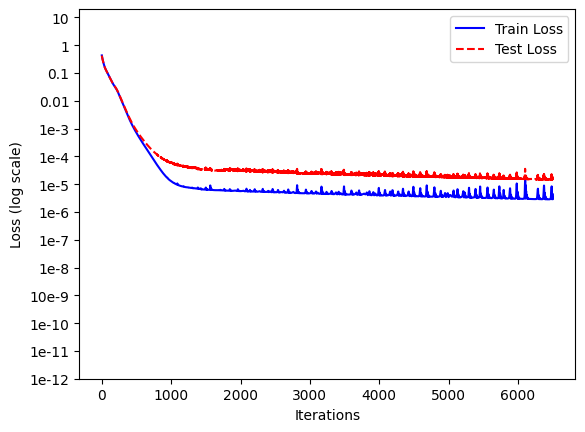

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

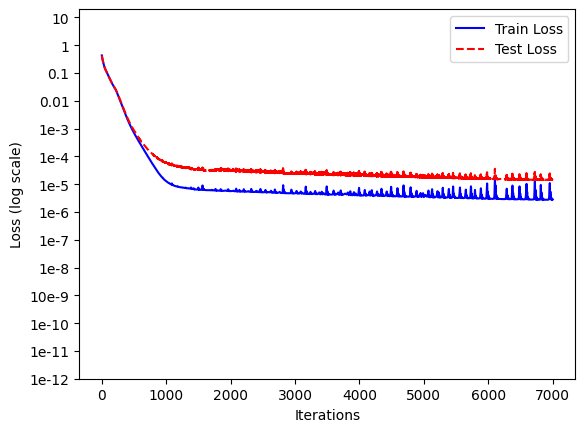

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4


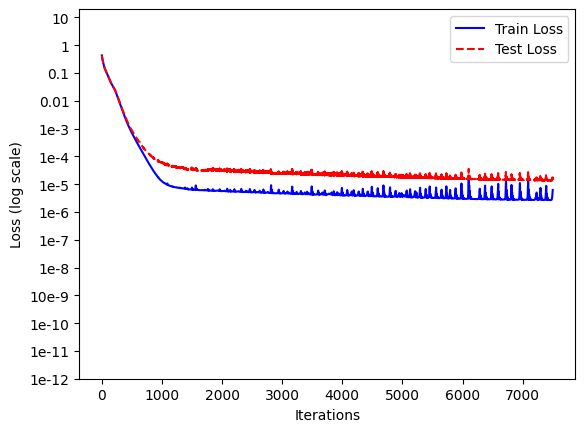

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4


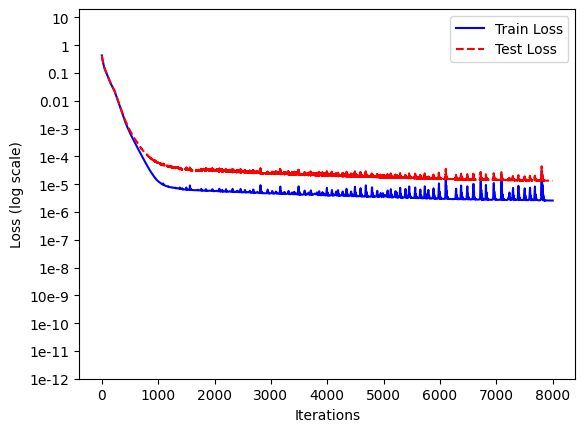

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4


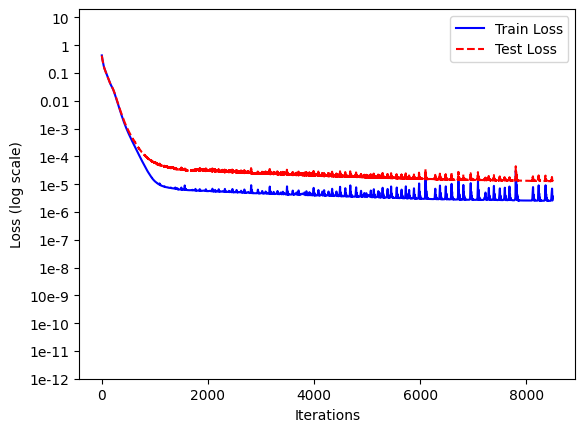

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4


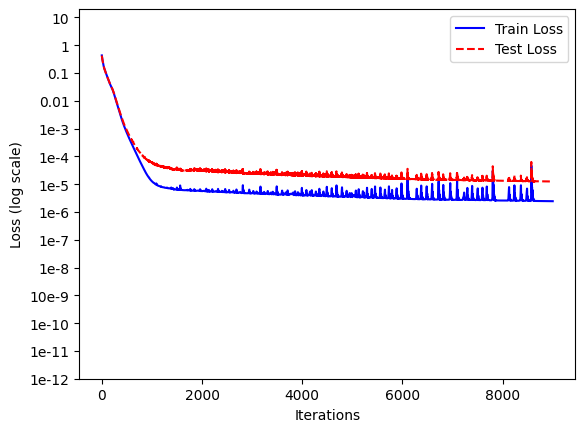

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4


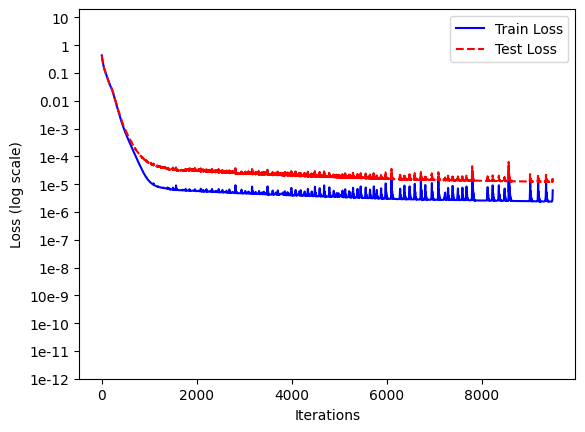

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
0
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4


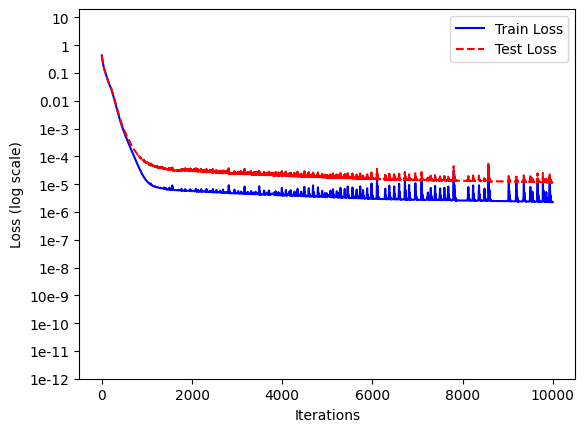

In [8]:
#Initialisation
W_branch, b_branch = model.hyper_initial(layers_f)
#W_trunk, b_trunk = model.hyper_initial(layers_x)

#%%
from torch.optim.lr_scheduler import ReduceLROnPlateau
n = 0
nmax = 10000
lr = 1e-4
start_time = time.perf_counter()
time_step_0 = time.perf_counter()
l2_reg_strength = 1e-5  # You can adjust this value
#l2_reg_strength = 4.95e-2  # You can adjust this value


optimizer = optim.Adam(list(W_branch) + list(b_branch), lr=lr,  weight_decay=l2_reg_strength) #c'est cette optim que jutilise
#optimizer = optim.SGD(list(W_branch) + list(b_branch), lr=lr,  weight_decay=l2_reg_strength) #c'est cette optim que jutilise



# optimizer = optim.Adam(list(W_branch) + list(b_branch) + list(W_trunk) + list(b_trunk), lr=lr,  weight_decay=l2_reg_strength) #c'est cette optim que jutilise
#optimizer = optim.SGD(list(W_branch) + list(b_branch) + list(W_trunk) + list(b_trunk), lr=lr,  weight_decay=l2_reg_strength)
scheduler = ReduceLROnPlateau(optimizer=optimizer)

data_loss_list = []
loss_ortho_list = []
train_err_list = []
test_err_list = []
train_loss_list = []
test_loss_list = []

# yy = model.fnn_B(v_train_tensor, W_branch, b_branch) #sortie branch net
# xx = ortho(POD, TOL=1e-8) #modes POD orthonormalisés

try:
    while n <= nmax:
        x_train_tensor = torch.from_numpy(x_y_train).float()
        x_train_tensor.requires_grad_(True)
        v_train_tensor = torch.from_numpy(v_train).float()
        u_train_tensor = torch.from_numpy(u_train).float()

        loss_train, u_train_pred = train_ortho(model, W_branch, b_branch, v_train_tensor, u_train_tensor,optimizer,POD)
        #loss_train, u_train_pred, data_loss = train_step(model, W_branch, b_branch, W_trunk,
                                              #b_trunk, v_train_tensor, x_train_tensor, u_train_tensor,
                                              #optimizer)


        #     #err_train = np.mean(np.linalg.norm(u_train - u_train_pred, 2, axis=1) /
        #                         np.linalg.norm(u_train, 2, axis=1))

        u_train_pred_np = u_train_pred.detach().numpy()

        err_train = np.mean(np.linalg.norm(u_train - u_train_pred_np, 2, axis=1) /
                            np.linalg.norm(u_train, 2, axis=1))

        loss_test, u_test_pred = test_step(model, W_branch, b_branch, v_test, u_test, optimizer, POD)
        err_test = np.mean(np.linalg.norm(u_test - u_test_pred, 2, axis=1) /
                           np.linalg.norm(u_test, 2, axis=1))

        if n % 10 == 0:
            print(f"Iteration: {n} Train_loss:{loss_train}, Test_loss: {loss_test}")
            #print(f"Iteration: {n} Train_loss:{loss_train}, Test_loss: {loss_test}, ortho_loss:{abs(loss_ortho)}")
            #print(f"Iteration: {n} Train_loss:{loss_train}, Test_loss: {loss_test}")
            #print(f"Iteration: {n} Train_loss:{loss_train}, ortho_loss:{abs(loss_ortho)}")

        train_err_list.append(err_train)
        test_err_list.append(err_test)
        train_loss_list.append(loss_train)
        test_loss_list.append(loss_test)
        #loss_ortho_list.append(loss_ortho)
        #data_loss_list.append(data_loss)

        if n % 500 == 0:
            gs = gridspec.GridSpec(1, 1)
            ax = plt.subplot(gs[:, :])
            plt.semilogy(range(len(train_loss_list)), train_loss_list, 'b-', label='Train Loss')
            plt.semilogy(range(len(test_loss_list)), test_loss_list, 'r--', label='Test Loss')
            #plt.semilogy(range(len(loss_ortho_list)), loss_ortho_list, 'g-.', label='Orthogonality Loss')


            #plt.plot(range(len(train_loss_list)), train_loss_list, 'b-', label='Train Loss')
            #plt.plot(range(len(test_loss_list)), test_loss_list, 'r--', label='Test Loss')
            #plt.semilogy(range(len(pde_loss_list)), pde_loss_list, 'g-.', label='PDE_t Loss')
            #plt.semilogy(range(len(data_loss_list)), data_loss_list, 'm:', label='Data_t loss')

            plt.xlabel('Iterations')
            plt.ylabel('Loss (log scale)')

            # Set the y-axis ticks and labels using a logarithmic scale
            yticks = [10 ** -12, 10 ** -11, 10 ** -10, 10 ** -9, 10 ** -8, 10 ** -7, 10 ** -6, 10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10 ** 0, 10 ** 1]
            yticklabels = ['1e-12', '1e-11', '1e-10','10e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '0.01', '0.1', '1','10']
            plt.yticks(yticks, yticklabels)
            # Set the y-axis limits
            ax.set_ylim([10 ** -12, 20])

            plt.legend()
            plt.show()

        n = n + 1

except KeyboardInterrupt:
    print("Training interrupted. Saving the model...")


In [12]:
u_test_pred[-1,:]

array([ 0.06148054,  0.03388232,  0.04211035,  0.04002107, -0.08347845,
        0.1895163 ,  0.20940101,  0.14603502,  0.16828623, -0.06890537,
       -0.11213169, -0.11585897, -0.06271292, -0.06880277, -0.10107207,
       -0.10376786, -0.1034923 ,  0.17075078,  0.14577483,  0.1027232 ,
        0.12120795,  0.16363832,  0.12411254,  0.18385439,  0.1265705 ,
       -0.0391137 , -0.05029418, -0.02528512, -0.01610683, -0.06619801,
       -0.09854935, -0.0759921 , -0.05892621, -0.05998577, -0.08887397,
       -0.03400464, -0.02460473, -0.03056989, -0.06083488, -0.07340337,
       -0.06914451, -0.09177406, -0.05484024, -0.08700037, -0.04901221,
       -0.03975055, -0.05054633, -0.04033545, -0.07075105,  0.06382567],
      dtype=float32)

In [9]:
u_test[-1,:]

array([ 0.06883845+0.00114446j,  0.03412022+0.00062461j,
        0.04393677+0.0007734j ,  0.03981338+0.00067277j,
       -0.07788142-0.00112317j,  0.1940907 +0.00324589j,
        0.21623595+0.00358418j,  0.14762109+0.00251557j,
        0.16873229+0.00285123j, -0.0742545 -0.00123911j,
       -0.11289695-0.00196726j, -0.11183198-0.00189277j,
       -0.06208783-0.00098533j, -0.07131351-0.00108854j,
       -0.098392  -0.00154852j, -0.10103942-0.00169702j,
       -0.10157644-0.00165564j,  0.17227789+0.00284303j,
        0.14817049+0.0025452j ,  0.10547763+0.0018347j ,
        0.13191255+0.00219091j,  0.16233592+0.00273176j,
        0.12230017+0.00208495j,  0.19174514+0.00329596j,
        0.13335343+0.00232625j, -0.0437927 -0.00086526j,
       -0.04829328-0.0010202j , -0.0255081 -0.00044685j,
       -0.01997452-0.00029615j, -0.07404684-0.00108975j,
       -0.09175419-0.00141607j, -0.07740563-0.00118708j,
       -0.05126883-0.00101399j, -0.06488973-0.00147256j,
       -0.08796067-0.00173823j,

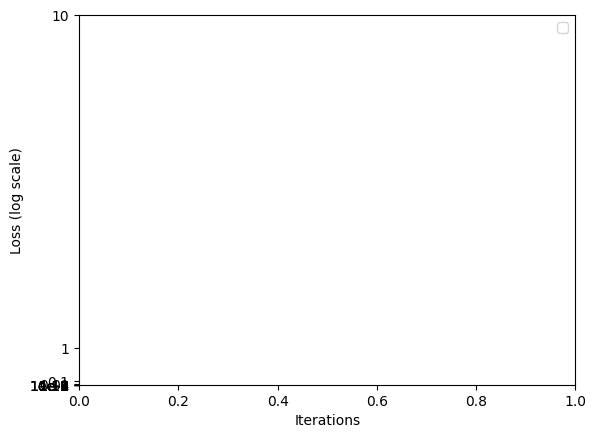

In [ ]:
plt.xlabel('Iterations')
plt.ylabel('Loss (log scale)')

# Set the y-axis ticks and labels using a logarithmic scale
yticks = [10 ** -12, 10 ** -11, 10 ** -10, 10 ** -9, 10 ** -8, 10 ** -7, 10 ** -6, 10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10 ** 0, 10 ** 1]
yticklabels = ['1e-12', '1e-11', '1e-10','10e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '0.01', '0.1', '1','10']
plt.yticks(yticks, yticklabels)
# Set the y-axis limits
ax.set_ylim([10 ** -12, 20])

plt.legend()
plt.show()